Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

# I. Wrangle Data

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
def wrangle(filepath):
    # Establish path to datafiles
    DATA_PATH = '../data/class-project/LoanApproval/'
    
    # Read in the data
    df = pd.read_csv(DATA_PATH + filepath)
    
    # Drop high-cardinality column, 'Loan_ID'
    threshold = 10 
    high_card_cols = [col for col in df.select_dtypes('object').columns
                     if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)
      
    # Fill NaN values in 'LoanAmount' column = continuous variable, will fill with median value
    # Will impute remaining NaNs later with a strategy='most_frequent'
    df['LoanAmount'].fillna(value=df['LoanAmount'].median(), inplace=True)

    # Feature Engineering
    # No features are being built based on the target; should not be any leakage
    
    # Applicant Income to LoanAmount
    # Total Income to LoanAmount
    # Loan Amount to Loan_Amount_Term
    
    return df

train_path = 'train_data.csv'
test_path = 'test_data.csv'

train = wrangle(train_path)
test = wrangle(test_path)

In [7]:
print(train.shape, test.shape)
train.head()

(614, 12) (367, 11)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [9]:
print(train.select_dtypes('object').nunique().sort_values())

list(train.select_dtypes('object').columns)

Gender           2
Married          2
Education        2
Self_Employed    2
Loan_Status      2
Property_Area    3
Dependents       4
dtype: int64


['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [10]:
# Has three features

train['Property_Area'].value_counts(normalize=True)

Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64

In [11]:
# Examine the distribution of the binary variable - this is our target 

train['Loan_Status'].value_counts(dropna=False)

Y    422
N    192
Name: Loan_Status, dtype: int64

In [12]:
# Examine for NaN values - will need an imputer

train.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
train['Dependents'].value_counts(normalize=True)

0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64

In [14]:
train['Credit_History'].value_counts(normalize=True)

1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64

In [15]:
# Don't forget some bar plot some of categorical normalized distribution
# Don't forget to histogram plot some of the continuous variables

In [16]:
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [17]:
train['LoanAmount'].isna().sum()

0

In [18]:
train['LoanAmount'].median()

128.0

# II. Split the Data

In [19]:
# Data is divided into training and test data.  Will separate training into train/validation set. 
# Will use a random split; there is no datetime information included in this dataset.

In [20]:
# Target for this data set is 'Loan_Status'
# 'Loan Status is a binary feature (approved/not-approved) == CLASSIFICATION PROBLEM
 
# Split the Data into a Feature Matrix (FM) and Target Vector (TV)

target = 'Loan_Status'
y = train['Loan_Status']
X = train.drop(labels='Loan_Status', axis=1)

In [21]:
print(type(y), y.shape, type(X), X.shape)

<class 'pandas.core.series.Series'> (614,) <class 'pandas.core.frame.DataFrame'> (614, 11)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish a Baseline

In [23]:
# Examine the distribution of the Target Vector - 'Loan_Status'
# It is a binary categorical variable - approved or not approved
# The classes of the Target Vector are moderately imbalanced towards approval
# Since this is a classification problem we will be looking at accuracy 
# You have a 69.65% chance of being correct if you always decide that the loan was approved; this is our baseline
# to beat

print(y_train.value_counts(normalize=True), "\n")
print('Baseline Accuracy: {:.4f}'.format(y_train.value_counts(normalize=True)[0]))

Y    0.696538
N    0.303462
Name: Loan_Status, dtype: float64 

Baseline Accuracy: 0.6965


In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 83 to 102
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             479 non-null    object 
 1   Married            490 non-null    object 
 2   Dependents         480 non-null    object 
 3   Education          491 non-null    object 
 4   Self_Employed      467 non-null    object 
 5   ApplicantIncome    491 non-null    int64  
 6   CoapplicantIncome  491 non-null    float64
 7   LoanAmount         491 non-null    float64
 8   Loan_Amount_Term   479 non-null    float64
 9   Credit_History     451 non-null    float64
 10  Property_Area      491 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 46.0+ KB


# IV. Build Models
- `LogisticRegression`
    
    - `OneHotEncoder`
    - `SimpleImputer`
    - `StandardScaler`
 
- `RandomForrestClassifier`

    - `OrdinalEncoder`
    - `SimpleImputer`

In [25]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Married', 'Dependents',
                                     'Education', 'Self_Employed',
                                     'Property_Area'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [39]:
# Model 2: Random Forest Classifier

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(random_state=42)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

In [40]:
# Classification: Is your majority class frequency >= 50% and < 70% ? 
# If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. 
# What evaluation metric will you choose, in addition to or instead of accuracy?

# Our majority class is less than 70% and can just use accuracy.  Should, however, come back and build out a 
# confusion_matrix, and look at recall/precision.  Will also explore Precision, Recall, and F1 Score.

In [41]:
# Training and Validation accuracy of our Logistic Regression model

print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.8187372708757638
Validation Accuracy (LOGR): 0.7886178861788617


In [42]:
# Training and Validation accuarcy of our Random Forest model
# Model appears to be overfit

print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Valdiation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Valdiation Accuracy (RF): 0.7804878048780488


#### Precision, Recall, F1 Score

In [43]:
# Not very good precision for Y, great recall for Y

print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           N       0.95      0.42      0.58        43
           Y       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



In [44]:
# Not very good precision for Y, great recall for Y

print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           N       0.86      0.44      0.58        43
           Y       0.76      0.96      0.85        80

    accuracy                           0.78       123
   macro avg       0.81      0.70      0.72       123
weighted avg       0.80      0.78      0.76       123



## ROC Curve

- To evalute models for binary classification
- To decide what probability threshold you should use when making your predictions

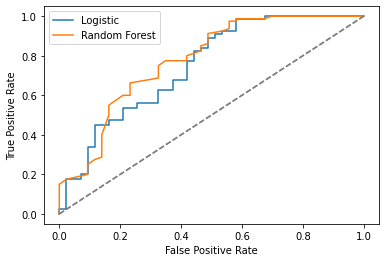

In [55]:
# Use VALIDATION DATA

# ROC curve is used with classification problems
# 'How far up can I go without having to go too far to the right?'
# An ROC curve let's you see how your model will perform at various thresholds
# Also allows you to compare different models 

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rd = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [59]:
# print('Logistic: ROA-AUC Score:', roc_auc_score(y_val, model_lr.predict(X_val)))
# print('Random Forest: ROC-AUC Score:', roc_auc_score(y_val, model_rf.predict(X_val)))

# roc_auc_score(y_val, model_lr.predict(X_val))

# Need to convert Y/N to 1 and 0 ??? 

y_val

350    Y
377    Y
163    Y
609    Y
132    Y
      ..
231    Y
312    Y
248    Y
11     Y
333    Y
Name: Loan_Status, Length: 123, dtype: object

In [ ]:
# Need confusion matrix
# Need plotting of some variables
# Need tuning of model
# Need to search for and plot most important features ------ (coefficients for the Logistic Regression model)